In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
import copy
from numpy.random import default_rng
np.random.seed(1)
import os
import requests
import zipfile
from tqdm import tqdm
import pandas as pd


def process_data():
  # load the data
  dirname = os.getcwd()
  folder_path = os.path.join(dirname, '')

  train_data_path = os.path.join(folder_path, 'train_data_FD001.txt')
  train_data = pd.read_csv(train_data_path)
  train_data.set_index('time_in_cycles')

  test_data_path = os.path.join(folder_path, 'test_data_FD001.txt')
  test_data = pd.read_csv(test_data_path)
  test_data.set_index('time_in_cycles')

  # retrieve the max cycles per engine: RUL
  train_rul = pd.DataFrame(train_data.groupby('engine_no')['time_in_cycles'].max()).reset_index()
  # merge the RULs into the training data
  train_rul.columns = ['engine_no', 'max']
  train_data = train_data.merge(train_rul, on=['engine_no'], how='left')
  # add the current RUL for every cycle
  train_data['RUL'] = train_data['max'] - train_data['time_in_cycles']
  train_data.drop('max', axis=1, inplace=True)

  # drop the columns not needed
  cols_nan = train_data.columns[train_data.isna().any()].tolist()
  cols_const = [ col for col in train_data.columns if len(train_data[col].unique()) <= 2 ]

  cols_irrelevant = ['operational_setting_1', 'operational_setting_2', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13']

  # Drop the columns without or with constant data
  train_data = train_data.drop(columns=cols_const + cols_nan + cols_irrelevant)
  test_data = test_data.drop(columns=cols_const + cols_nan + cols_irrelevant)

  # define the columns for training
  train_data_inputs = train_data.copy()
  train_data_inputs.drop(columns=['RUL', 'engine_no', 'time_in_cycles'], inplace=True)
  training_columns = train_data_inputs.columns

  return train_data, test_data,training_columns

WINDOW_SIZE = 1
def transform_to_windowed_data(dataset, window_size, window_limit = 0, verbose = True):

  features = []
  labels = []

  dataset = dataset.set_index('time_in_cycles')
  data_per_engine = dataset.groupby('engine_no')

  for engine_no, engine_data in data_per_engine:
      # skip if the engines cycles are too few
      if len(engine_data) < window_size + window_limit -1:
        continue

      if window_limit != 0:
        window_count = window_limit
      else:
        window_count = len(engine_data) - window_size

      for i in range(0, window_count):
        # take the last x cycles where x is the window size
        start = -window_size - i
        end = len(engine_data) - i
        inputs = engine_data.iloc[start:end]
        # use the RUL of the last cycle as label
        outputs = engine_data.iloc[end - 1, -1]

        inputs = inputs.drop(['engine_no', 'RUL'], axis=1)

        features.append(inputs.values)
        labels.append(outputs)

  features = np.array(features)
  labels = np.array(labels)
  labels = np.expand_dims(labels, axis=1)

  if verbose:
    print("{} features with shape {}".format(len(features), features[0].shape))
    print("{} labels with shape {}".format(len(labels), labels.shape))

  return features, labels


def process_data_final():
    train_data, test_data, training_columns = process_data()
    x_train, y_train = transform_to_windowed_data(train_data, WINDOW_SIZE)
    x_test, y_test = transform_to_windowed_data(test_data, WINDOW_SIZE)


    # clip RUL values
    rul_clip_limit = 110
    y_train = y_train.clip(max=rul_clip_limit)
    y_test = y_test.clip(max=rul_clip_limit)

    #  Data Normalization

    # transform to torch tensor
    tensor_x_train = torch.Tensor(x_train)
    tensor_y_train = torch.Tensor(y_train)
    tensor_x_test = torch.Tensor(x_test)
    tensor_y_test = torch.Tensor(y_test)

    #  Data Normalization
    train_mean = tensor_x_train.mean(0)
    train_std = tensor_x_train.std(0)
    tensor_x_train = (tensor_x_train - train_mean) / train_std

    test_mean = tensor_x_test.mean(0)
    test_std = tensor_x_test.std(0)
    tensor_x_test = (tensor_x_test - test_mean) / test_std

    # create datasets for train, test and validation
    train_dataset = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
    test_dataset = torch.utils.data.TensorDataset(tensor_x_test, tensor_y_test)

    # create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=120)

    return train_loader, test_loader



In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(11, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 24)
        self.fc4 = nn.Linear(24, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x[:, -1, :]

        return x

In [3]:
train_loader, test_loader = process_data_final()

20531 features with shape (1, 11)
20531 labels with shape (20531, 1)
12996 features with shape (1, 11)
12996 labels with shape (12996, 1)


In [4]:
class Worker():
    def __init__(self, ids, learning_rate, model, train_data, test_data):
        self.id = ids
        self.learning_rate = learning_rate
        self.model = model
        self.train_input, self.train_output = train_data
        self.test_input, self.test_output = test_data
        self.opt = optim.SGD(params=self.model.parameters(),lr=self.learning_rate)
        self.model_evaluation = {}

    def train_my_model(self):
        criterion = nn.L1Loss()
        self.model.train()
        self.opt.zero_grad()
        pred = self.model(self.train_input)
        loss = criterion(pred, self.train_output)
        loss.backward()
        self.opt.step()
        loss = loss.item()
        return loss

    def test_my_model(self):
        criterion = nn.L1Loss()
        self.model.eval()
        with torch.no_grad():
            output = self.model(self.test_input)
            loss = criterion(output, self.test_output).item()
            return loss

    def test_other_model(self, ids, model_1, results):
        criterion = nn.L1Loss()
        model_1.eval()
        with torch.no_grad():
            output = model_1(self.test_input)
            loss = criterion(output, self.test_output).item()
            results[self.id][ids] = round(loss,3)
            return loss

    def test_final_model(self, model_1):
        criterion = nn.L1Loss()
        model_1.eval()
        with torch.no_grad():
            output = model_1(self.test_input)
            loss = criterion(output, self.test_output).item()
            return loss

In [5]:
def report_outlier(result):
        outliers = []
        data_std = np.std(result)
        data_mean = np.mean(result)
        anomaly_cut_off = data_std * 2
        lower_limit = data_mean - anomaly_cut_off
        upper_limit = data_mean + anomaly_cut_off

        for index, loss in enumerate(result):
            if loss > upper_limit or loss < lower_limit:
                outliers.append(index)
        return outliers

def aggregate_model(models):
    model_agrregated = []
    for param in models[0].parameters():
      model_agrregated += [np.zeros(param.shape)]

    for model in models:
      i = 0
      for param in model.parameters():
        model_agrregated[i] += param.detach().numpy()

        i += 1

    model_agrregated = np.array(model_agrregated) / len(models)
    
    return model_agrregated

In [6]:
noise_factor = 15
model_original = Net()
model_outlier = Net()
size = 10
num_workers = 100
workers = {}
outliers = [4,18,25,33,45,50,61,77,84,99]

for index, (data, target) in enumerate(train_loader):
    if index == num_workers:
        test_worker = Worker(index, 0.1,copy.deepcopy(model_original), (data, target), (None, None))
        break

    if index in outliers:
        data = torch.rand(data.shape[0], data.shape[1], data.shape[2]) * noise_factor
        workers[index] = Worker(index, 0.1,copy.deepcopy(model_outlier), (data, target), (None, None))
    else:
        workers[index] = Worker(index, 0.1,copy.deepcopy(model_original), (data, target), (None, None))

    
    
for index, (data, target) in enumerate(test_loader):
    if index == num_workers:
        test_worker.test_input = data
        test_worker.test_output = target
        break
    if index in outliers:
        data = torch.rand(data.shape[0], data.shape[1], data.shape[2]) * noise_factor

    workers[index].test_input = data
    workers[index].test_output = target

torch.Size([120, 1, 11])
Test Worker Created..


In [7]:
import time

In [8]:
results = np.zeros((num_workers, num_workers))
iteration = 10
loss_results = np.zeros((2,iteration))
number_of_detected_outliers = np.zeros((iteration))
for itr in range(iteration):
    for node in workers:
        if node in outliers:
            continue
        for epoch in range(100):
            loss = workers[node].train_my_model()


    start_time = time.time()
    for master in workers:
        for slave in workers:
            if int(master/size) == int(slave/size):
                loss = workers[master].test_other_model(workers[slave].id, copy.deepcopy(workers[slave].model), results)

    complaints = np.zeros((num_workers))
    outliers_real = []
    start = 0
    end = 0
    for idx, result in enumerate(results):
        start = int(idx/size)*size
        end = start + size
        report = report_outlier(result[start:end])
        for index in report:
            complaints[index+start] += 1
        
    for idx, num_complain in enumerate(complaints):
        if num_complain >= int(size/2):
            outliers_real += [idx]
    print(outliers_real)
    number_of_detected_outliers[itr] = len(outliers_real)

    end_time = time.time()
    time_taken = end_time - start_time
    print(f'Time taken for validation is {time_taken}')

    models_all = []
    models_partial = []
    for w in workers:
        models_all += [workers[w].model]
        if w in outliers_real:
            continue

        models_partial += [workers[w].model]
            

    model_all_aggregate = aggregate_model(models_all)
    model_partial_aggregate = aggregate_model(models_partial)

    model_full = Net()
    for i, param in enumerate(model_full.parameters()):
        param.data = torch.from_numpy(model_all_aggregate[i]).type('torch.FloatTensor')

    model_partial = Net()
    for i, param in enumerate(model_partial.parameters()):
        param.data = torch.from_numpy(model_partial_aggregate[i]).type('torch.FloatTensor')

    loss_all = test_worker.test_final_model(model_full)
    loss_partial = test_worker.test_final_model(model_partial)
    print(f'Loss is {loss_all},{loss_partial}')
    loss_results[0][itr] = loss_all
    loss_results[1][itr] = loss_partial

[50, 84]
Time taken for validation is 0.7925724983215332
Loss is 97.7451171875,97.35951232910156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[4, 45, 50, 61, 77, 84]
Time taken for validation is 0.7755835056304932
Loss is 91.78089141845703,89.89899444580078
[25, 45, 50, 61, 77, 84]
Time taken for validation is 0.7901999950408936
Loss is 90.8425521850586,88.92094421386719
[4, 18, 25, 45, 50, 61, 77, 84]
Time taken for validation is 0.7707920074462891
Loss is 89.34788513183594,86.56194305419922
[4, 18, 25, 33, 45, 50, 61, 77, 84]
Time taken for validation is 0.7970945835113525
Loss is 88.19232940673828,84.90418243408203
[4, 18, 25, 33, 45, 50, 61, 77, 84]
Time taken for validation is 0.8003015518188477
Loss is 86.83982849121094,83.39421081542969
[4, 18, 25, 45, 50, 61, 77, 84, 99]
Time taken for validation is 0.777616024017334
Loss is 85.36588287353516,81.72998809814453
[18, 25, 33, 45, 50, 61, 77, 84, 99]
Time taken for validation is 0.8252713680267334
Loss is 84.9561538696289,81.3380126953125
[4, 18, 25, 33, 45, 50, 61, 77, 84, 99]
Time taken for validation is 0.8036904335021973
Loss is 88.93962097167969,85.899169921875
[4, 

Text(0.5, 1.0, 'Model Loss over 100 FL Rounds')

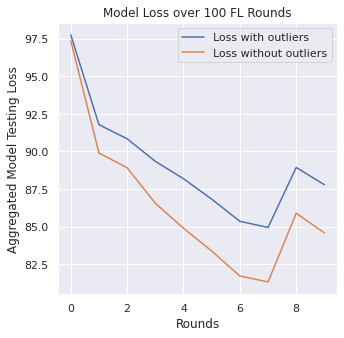

In [11]:
plt.figure(figsize = (5,5))
plt.xlabel('Rounds')
plt.ylabel('Aggregated Model Testing Loss')
plt.plot(range(iteration), loss_results[0], label='Loss with outliers')
plt.plot(range(iteration), loss_results[1], label='Loss without outliers')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.locator_params(axis="x", nbins=5)
plt.legend()
plt.title("Model Loss over 100 FL Rounds")

Text(0.5, 1.0, 'Number of detected outliers, True value = 10')

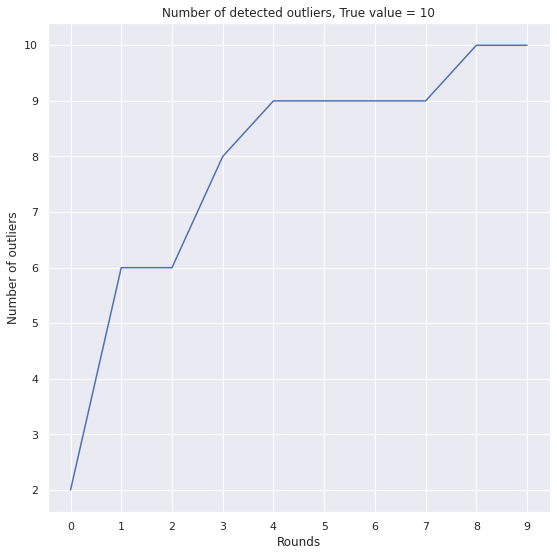

In [12]:
plt.figure(figsize = (9,9))
plt.xlabel('Rounds')
plt.ylabel('Number of outliers')
plt.plot(range(iteration), number_of_detected_outliers)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.locator_params(axis="x", nbins=10)
# plt.legend()
plt.title("Number of detected outliers, True value = 10")